In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"farhanrahmansyah","key":"14ee709ae8404a52eb60a3febad07e51"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Unduh dataset CIFAKE dari Kaggle
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

# Ekstrak dataset
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip -d cifake_data

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other


In [20]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

In [4]:
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    horizontal_flip=True
)

dataset_path = 'cifake_data'

train_gen = train_val_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_gen = train_val_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


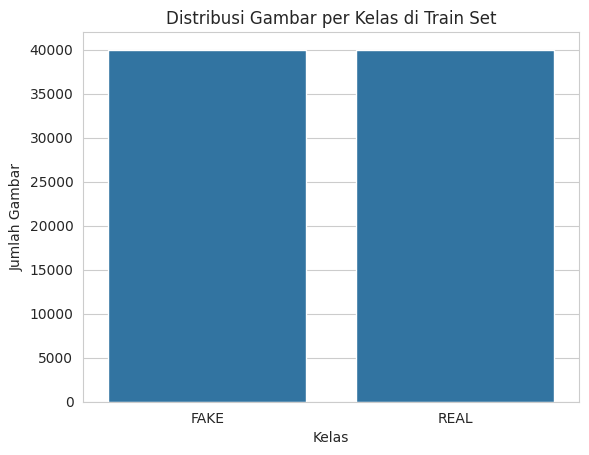

In [6]:
sns.set_style("whitegrid")
class_counts = pd.Series(train_gen.classes).value_counts().sort_index()
class_labels = list(train_gen.class_indices.keys())
sns.barplot(x=class_labels, y=class_counts.values)
plt.title("Distribusi Gambar per Kelas di Train Set")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.show()

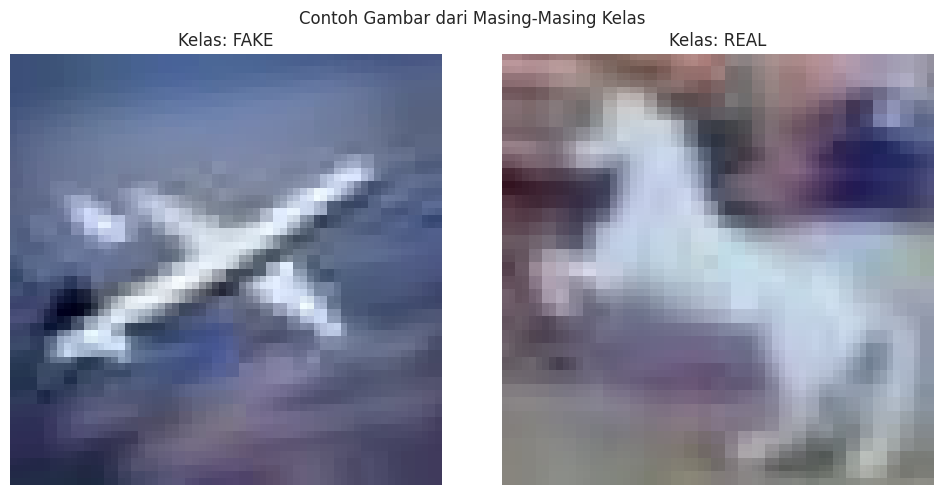

In [7]:
fig, axs = plt.subplots(1, len(class_labels), figsize=(10, 5))
for i, label in enumerate(class_labels):
    for img_batch, label_batch in train_gen:
        idx = np.argmax(label_batch, axis=1) == i
        if np.any(idx):
            axs[i].imshow(img_batch[idx][0])
            axs[i].set_title(f"Kelas: {label}")
            axs[i].axis('off')
            break
plt.suptitle("Contoh Gambar dari Masing-Masing Kelas")
plt.tight_layout()
plt.show()

In [8]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    # ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

In [11]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 186s 145ms/step - accuracy: 0.7615 - loss: 0.4769 - val_accuracy: 0.8706 - val_loss: 0.3063
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 163s 131ms/step - accuracy: 0.8696 - loss: 0.3089 - val_accuracy: 0.8969 - val_loss: 0.2558
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 158s 127ms/step - accuracy: 0.8937 - loss: 0.2603 - val_accuracy: 0.9065 - val_loss: 0.2347
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 158s 127ms/step - accuracy: 0.9048 - loss: 0.2358 - val_accuracy: 0.9193 - val_loss: 0.2033
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 200s 125ms/step - accuracy: 0.9116 - loss: 0.2184 - val_accuracy: 0.9091 - val_loss: 0.2163
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 157s 125ms/step - accuracy: 0.9171 - loss: 0.2094 - val_accuracy: 0.9232 - val_loss: 0.1934
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 205s 128ms/step - accuracy: 0.9247 - loss: 0.1902 - val_accuracy: 0.9276 - val_loss: 0.1817
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 203s 129ms/step - ac

In [12]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9622 - loss: 0.0996
Test Accuracy: 94.97%


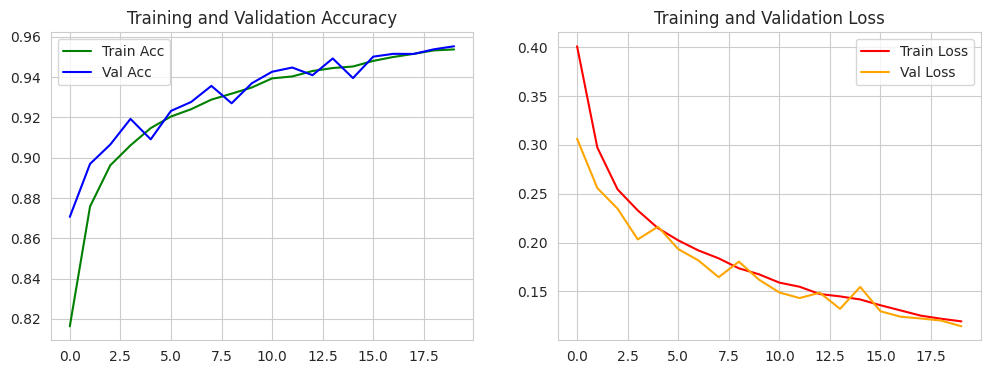

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Acc', color='green')
plt.plot(epochs_range, val_acc, label='Val Acc', color='blue')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', color='red')
plt.plot(epochs_range, val_loss, label='Val Loss', color='orange')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
              precision    recall  f1-score   support

        FAKE       0.93      0.97      0.95     10000
        REAL       0.97      0.93      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



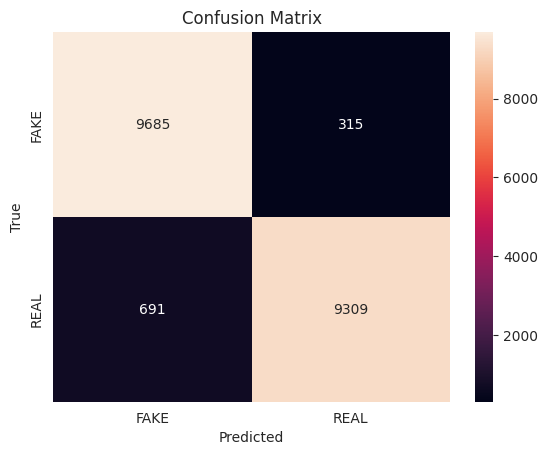

In [14]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
model.export("saved_model")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  138178580789008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138178580790928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138178580789776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138178563817936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138178563818896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138178563819856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138178580789392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138178563820432: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [16]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label.txt
with open("label.txt", "w") as f:
    for label in class_labels:
        f.write(f"{label}\n")


# Buat folder tflite dan pindahkan file
os.makedirs("tflite", exist_ok=True)
shutil.move("model.tflite", "tflite/model.tflite")
shutil.move("label.txt", "tflite/label.txt")

'tflite/label.txt'

In [19]:
!pip install tensorflowjs > /dev/null
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

2025-04-23 16:13:51.353888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745424831.375755   16766 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745424831.382698   16766 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-23 16:13:55.457046: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745424835.457332   16766 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━

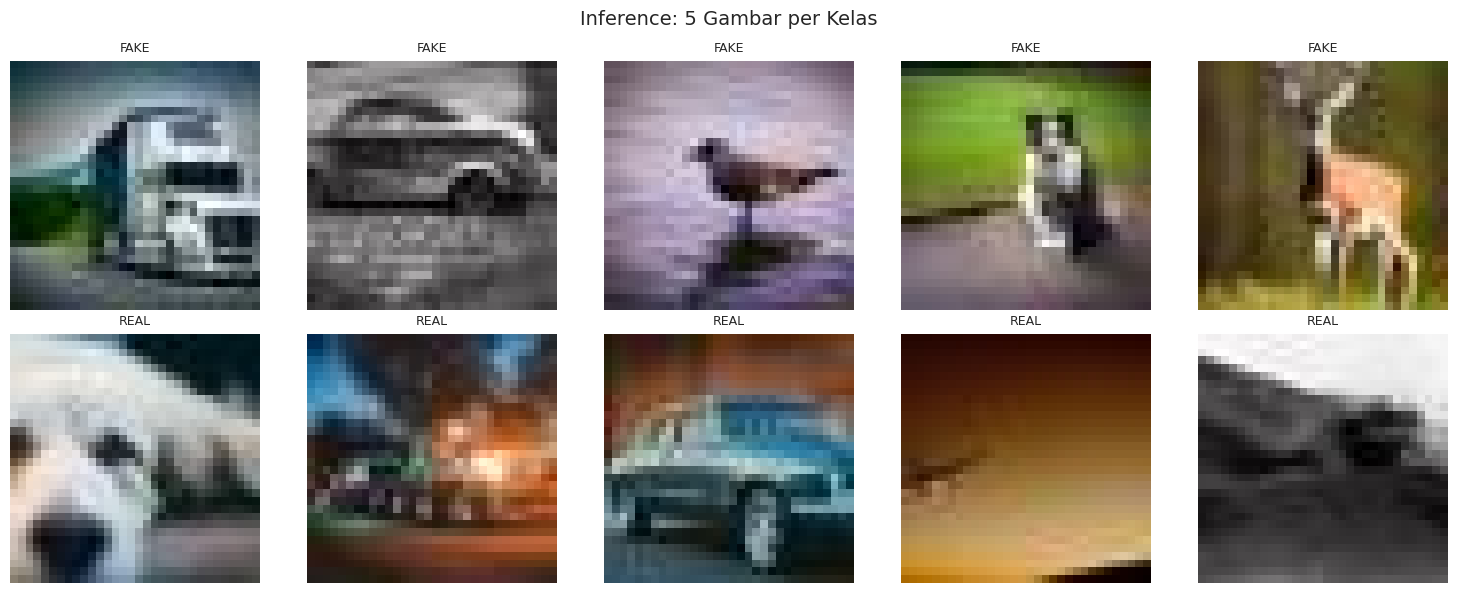

In [22]:
num_per_class = 5
class_indices = test_gen.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

plt.figure(figsize=(15, 6))
shown = {label: 0 for label in class_indices.keys()}

i = 0
n = 1
while any(v < num_per_class for v in shown.values()) and i < len(test_gen.filepaths):
    img_path = test_gen.filepaths[i]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(64, 64))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    pred_class_idx = np.argmax(prediction)
    pred_class = inv_class_indices[pred_class_idx]

    if shown[pred_class] < num_per_class:
        plt.subplot(len(class_indices), num_per_class, n)
        plt.imshow(mpimg.imread(img_path))
        plt.title(f"{pred_class}", fontsize=9)
        plt.axis('off')
        shown[pred_class] += 1
        n += 1

    i += 1

plt.suptitle("Inference: 5 Gambar per Kelas", fontsize=14)
plt.tight_layout()
plt.show()